# Introducción

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. El objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizaremos un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [4]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMClassifier

from tqdm.auto import tqdm

import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [6]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [8]:
try:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [9]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

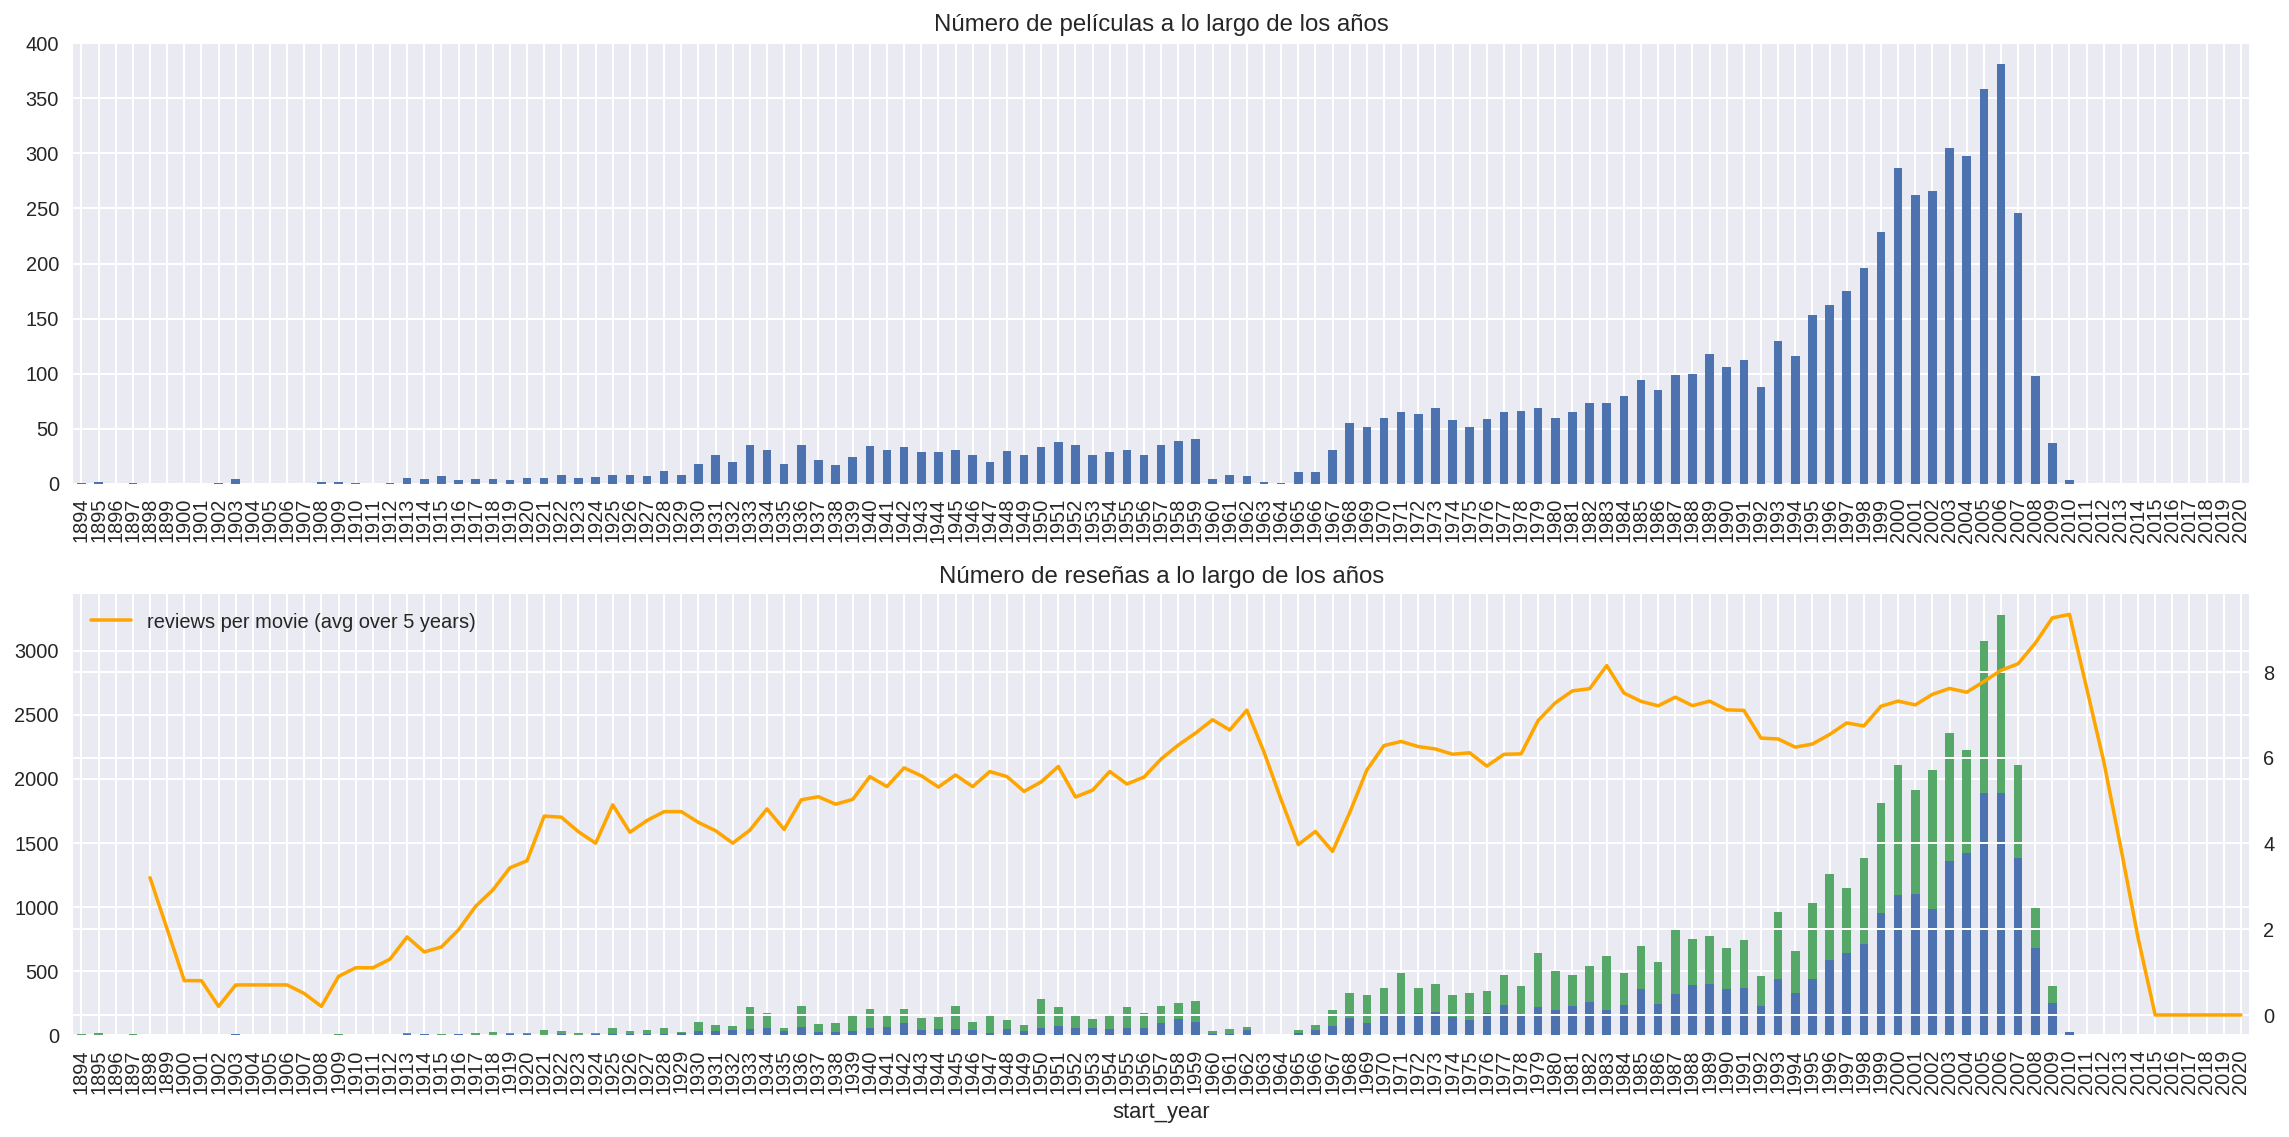

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

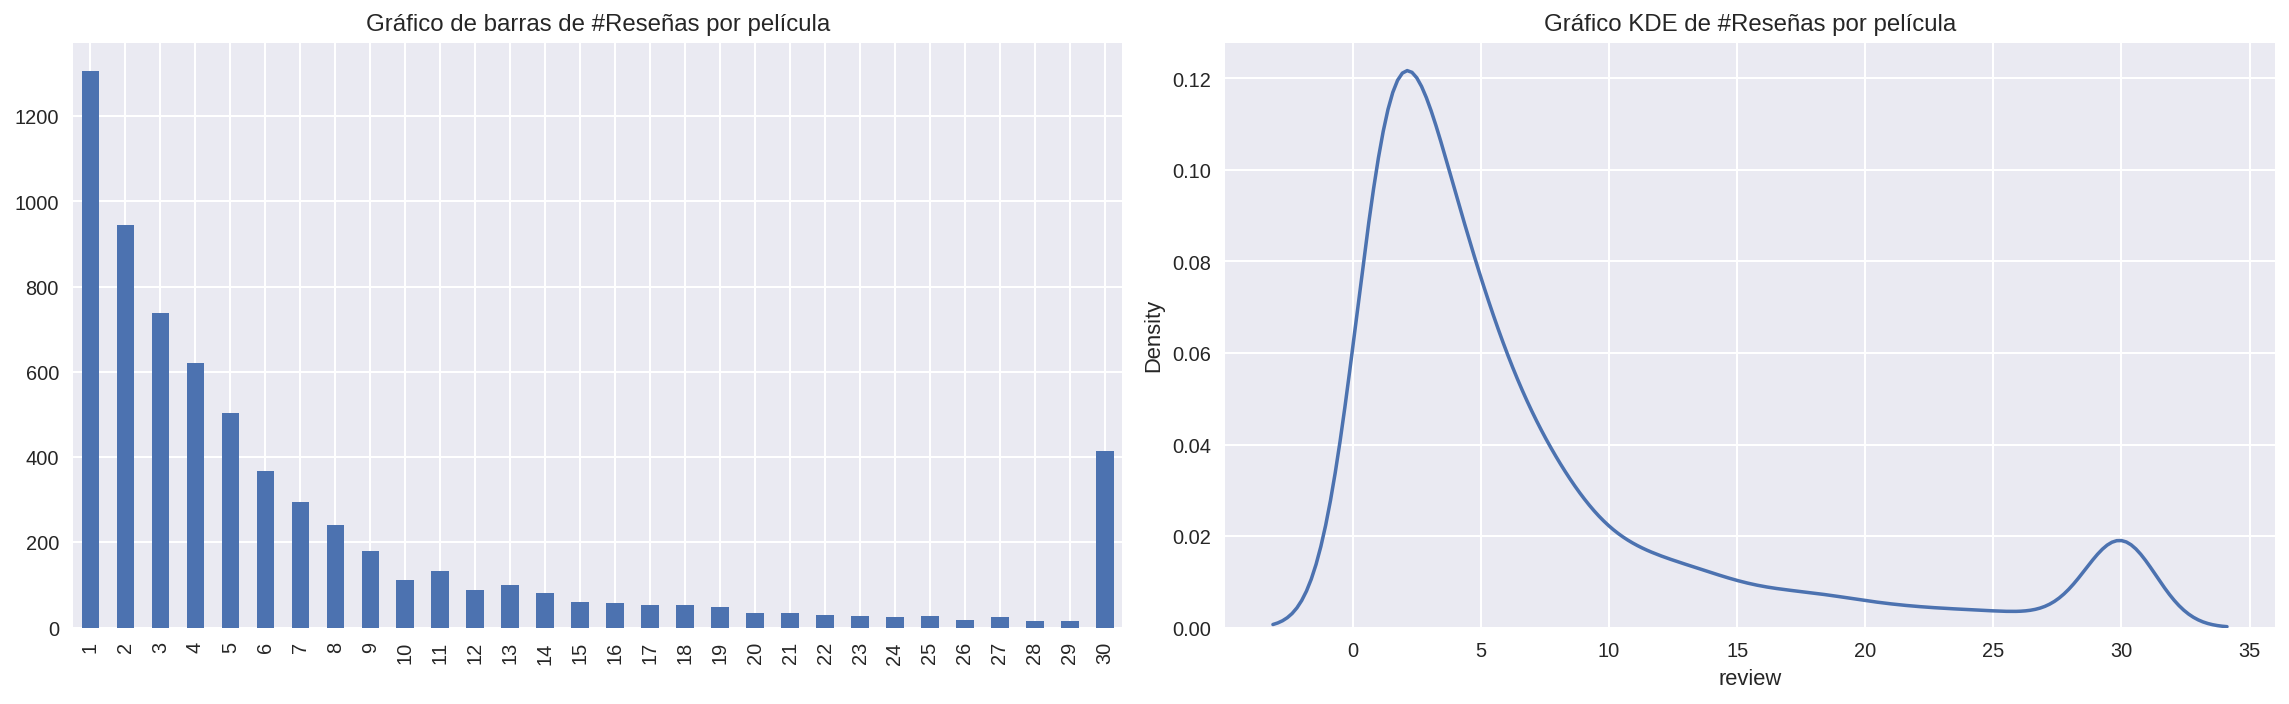

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [7]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

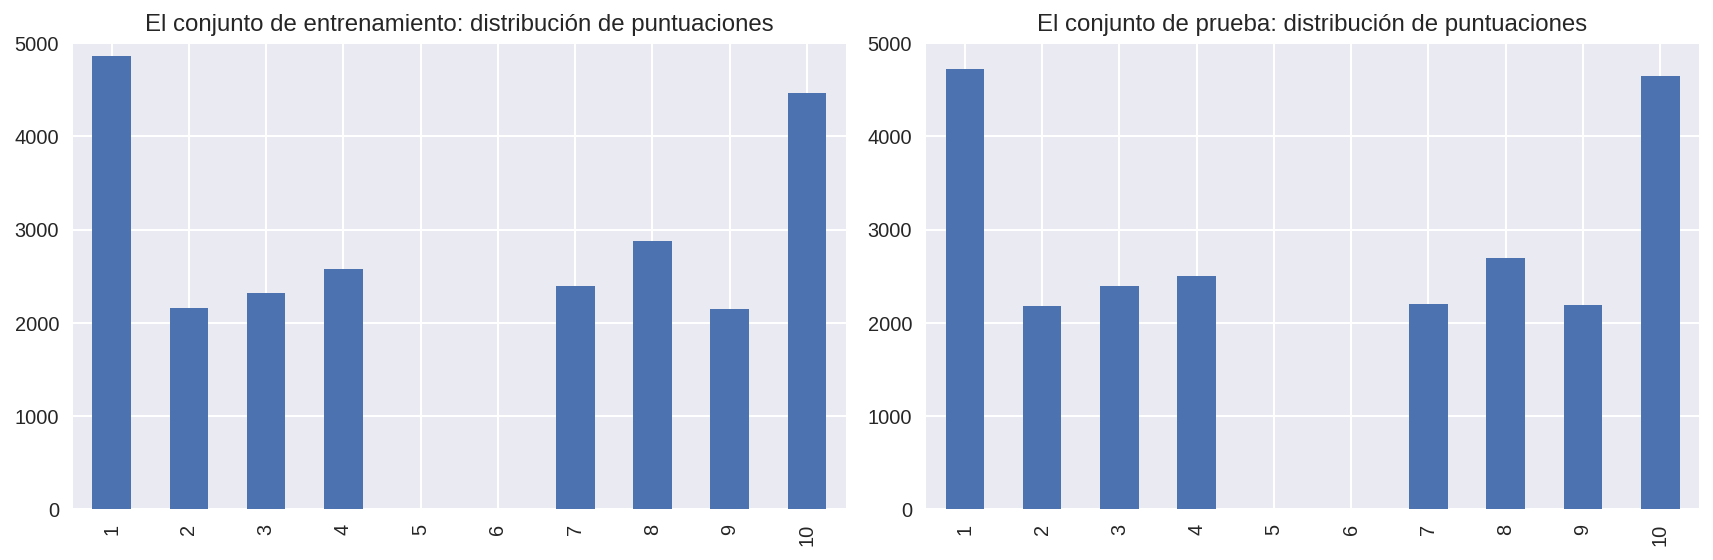

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


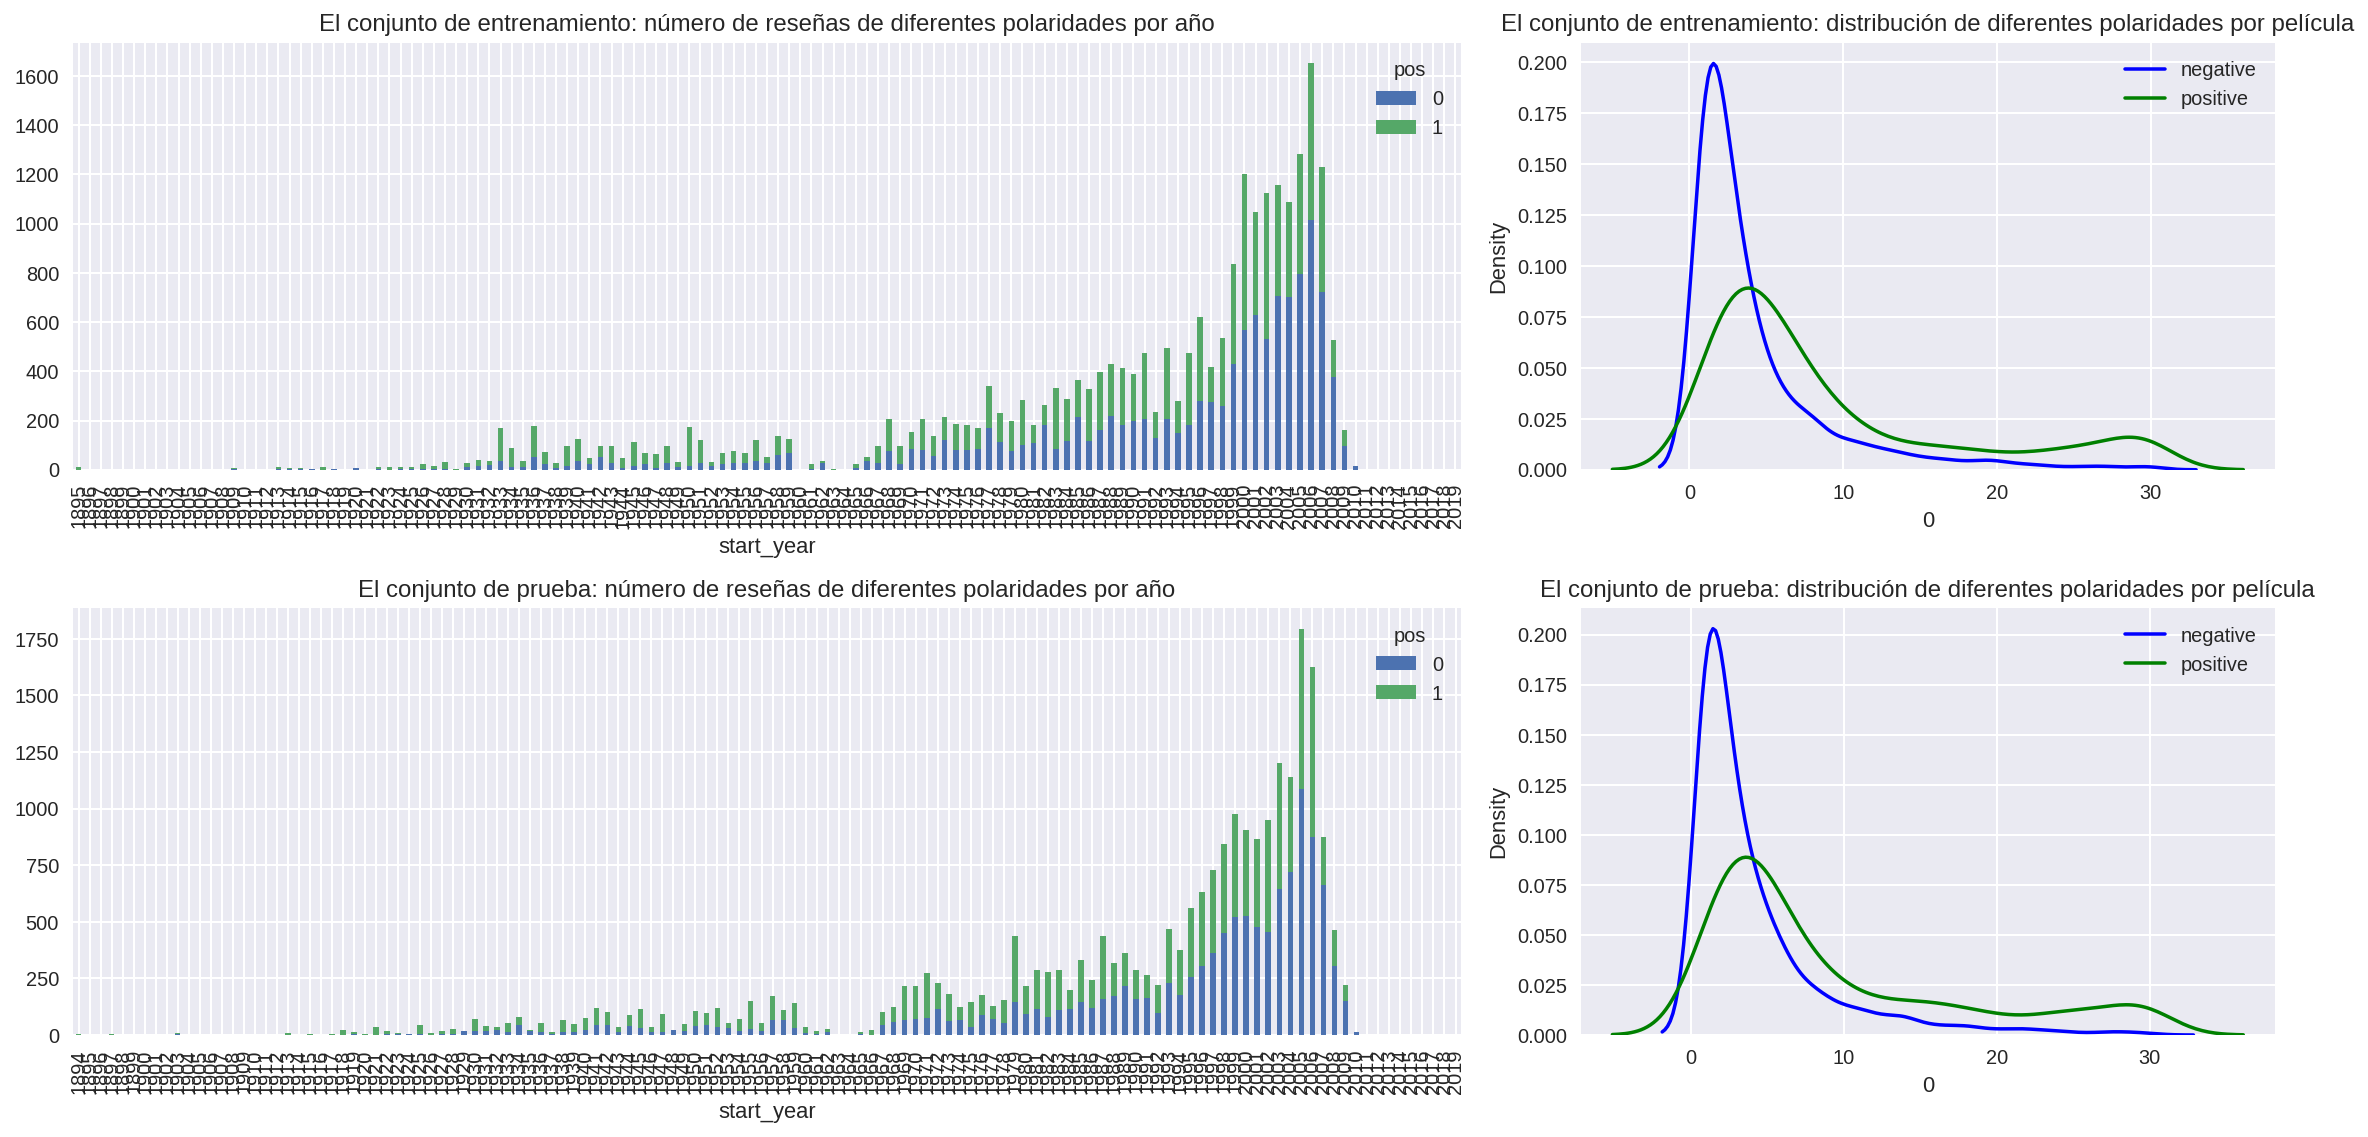

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [10]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [12]:
def clear_text(text):
    
    text = text.lower()
    
    pattern = r"[^a-zA-Z']"
    
    text = re.sub(pattern," ",text)
    text = text.split()
    text = " ".join(text)
    
    return text

In [13]:
df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)
df_reviews['review_norm'].iloc[0]

"the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but that's not what i got out of it i didn't get anything in the first half there's a new character without introduction in every other scene the first half hour is completely incomprehensible the rest is just one long annoying underlit chase scene there's always an irritating sound in the background whether it's a loud watch ticking a blaring siren a train whistling or even the horrible score by quincy jones there are a lot of parts that are laughably bad too like the bad guys chasing beatty on thin ice with a car or the police arriving at the scene roughly fifteen times i really hated this movie"

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [14]:
# Extraemos los conjuntos de datos para entrenamiento y prueba
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [15]:
from sklearn.dummy import DummyClassifier

In [16]:
train_features_0 = df_reviews_train.drop('review', axis= 1)
test_features_0 = df_reviews_test.drop('review', axis= 1)

model_0 = DummyClassifier()

           train  test
Exactitud    NaN   NaN
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


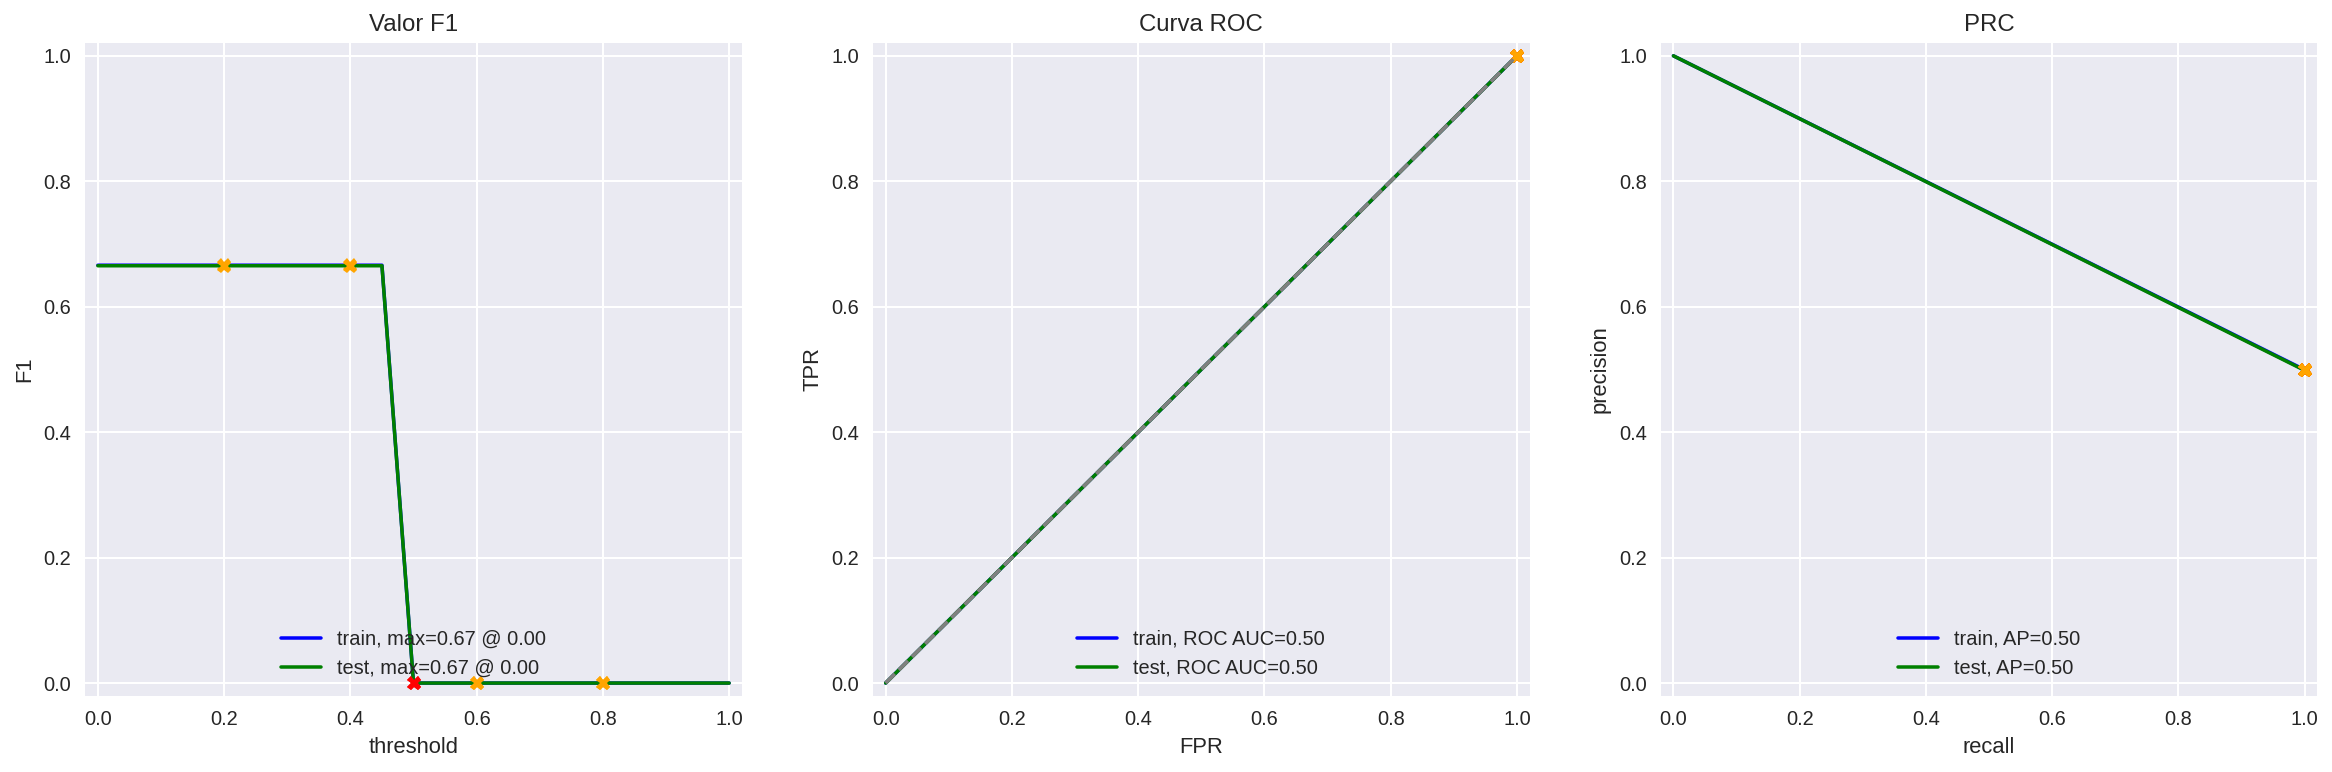

In [17]:
evaluate_model(model_0.fit(train_features_0, train_target), train_features_0, train_target, test_features_0, test_target)

**Conclusiones:**

Este modelo nos servirá como prueba de cordura ya que los valores de F1 curva ROC son muy bajos.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [19]:
# Definimos una función para lematizar con NLTK
lemmatizer  = WordNetLemmatizer()
def nltk_lematize(review):
    
    text = review
    tokens = word_tokenize(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    return " ".join(lemmas)

In [20]:
# Definimos nuestro review normalizado como el conjunto de características con lematización
corpus_train = df_reviews_train['review_norm'].apply(nltk_lematize)
corpus_test = df_reviews_test['review_norm'].apply(nltk_lematize)

stop_words = set(nltk_stopwords.words('english'))
cout_tf_idf = TfidfVectorizer(stop_words= stop_words)
train_features_1 = cout_tf_idf.fit_transform(corpus_train)
test_features_1 = cout_tf_idf.transform(corpus_test)

print('Train_features_1', train_features_1.shape)
print('Test_features_1', test_features_1.shape)

Train_features_1 (23796, 64299)
Test_features_1 (23535, 64299)


In [21]:
# Generamos el modelo
model_1 = LogisticRegression()
model_1 = model_1.fit(train_features_1, train_target)

           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


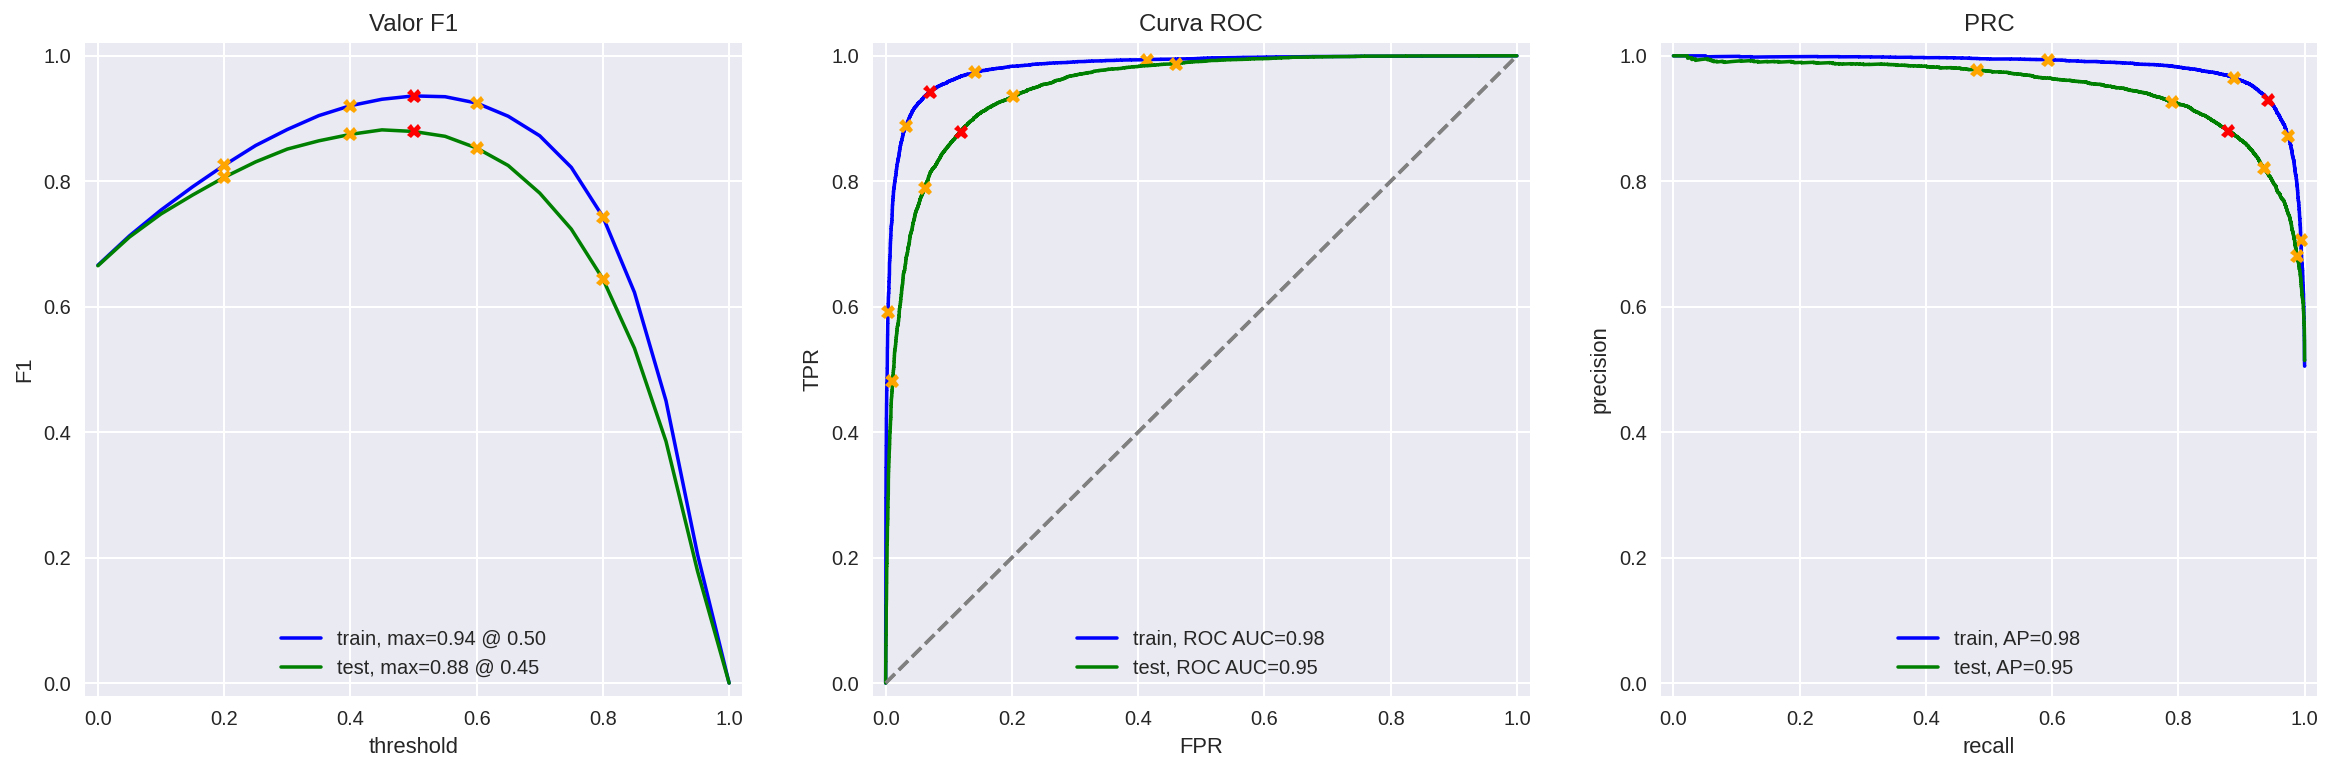

In [22]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

**Conclusiones:**

- Este modelo de regresión lineal con NLTK y TF-IDFR obtuvo valores muy interesantes, pero se puede evidenciar algo de sobreajuste ya que la métrica F1 para el conjunto de prueba es 6 puntos mas bajo.

### Modelo 3 - spaCy, TF-IDF y LR

In [23]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [24]:
# Definimos una función para lematizar con spacy
def spacy_lematize(review):
    
    doc = nlp(review)
    lemmas = [token.lemma_ for token in doc]
    
    return ' '.join(lemmas)

In [25]:
# Definimos nuestro review normalizado como el conjunto de características con lematización
corpus_train = df_reviews_train['review_norm'].apply(spacy_lematize)
corpus_test = df_reviews_test['review_norm'].apply(spacy_lematize)

stop_words = set(nltk_stopwords.words('english'))
cout_tf_idf = TfidfVectorizer(stop_words= stop_words)
train_features_2 = cout_tf_idf.fit_transform(corpus_train)
test_features_2 = cout_tf_idf.transform(corpus_test)

print('Train_features_2', train_features_2.shape)
print('Test_features_2', test_features_2.shape)

Train_features_2 (23796, 59139)
Test_features_2 (23535, 59139)


In [26]:
# Generamos el modelo
model_2 = LogisticRegression()
model_2 = model_2.fit(train_features_2, train_target)

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


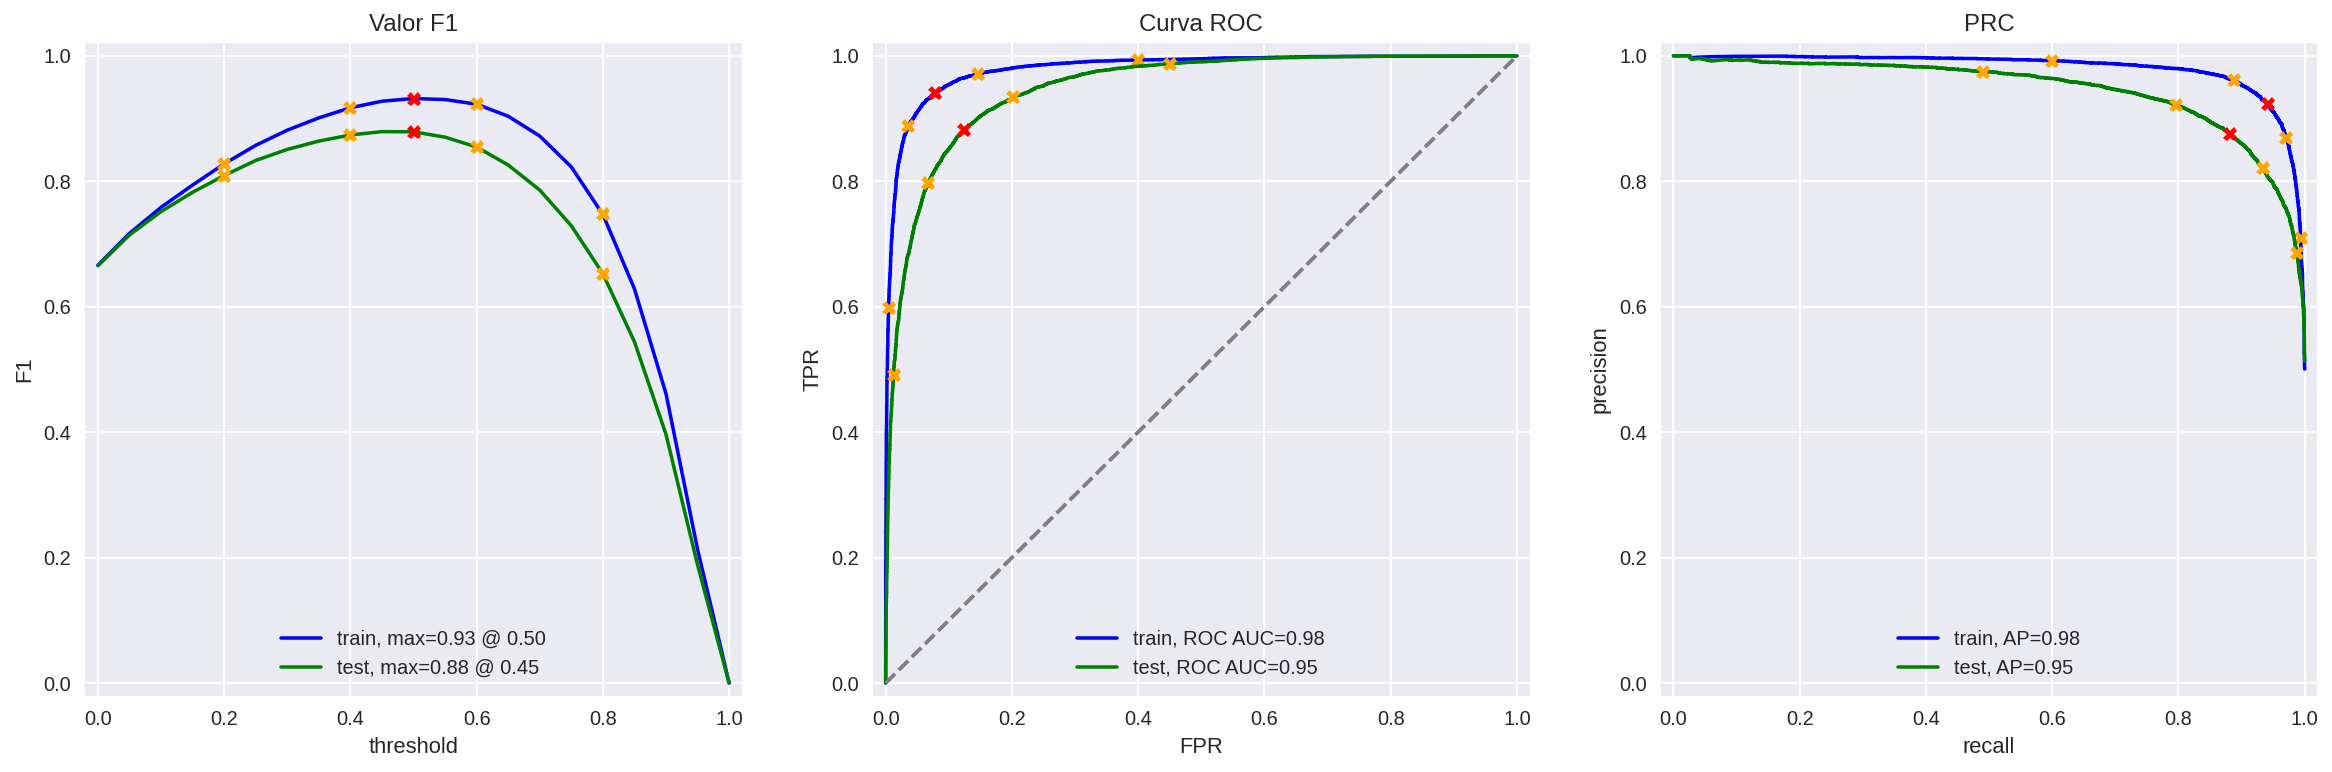

In [27]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

**Conclusiones:**

- Este modelo de regresión lineal con spacy y TF-IDFR obtuvo valores muy similares  pero se puede evidenciar algo de sobreajuste ya que la métrica F1 para el conjunto de prueba es 6 puntos mas bajo.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [29]:
train_features_3 = train_features_2.copy()
test_features_3 = test_features_2.copy()

params = {
    'max_depth':[-1,5,10],
    'learning_rate':[0.1,0.5,1],
    'n_estimators': [100,150,200],
    'random_state': [42]
}

model_lgbm = LGBMClassifier()

grid = GridSearchCV(estimator= model_lgbm, param_grid= params, scoring= 'f1', cv= 3)

grid.fit(train_features_3, train_target)

print(grid.best_params_)

{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'random_state': 42}


In [30]:
model_3 = LGBMClassifier(max_depth= -1, learning_rate= 0.1, n_estimators= 200, random_state= 42)
model_3 = model_3.fit(train_features_3, train_target)

           train  test
Exactitud    NaN   NaN
F1          0.96  0.87
APS         0.99  0.94
ROC AUC     0.99  0.94


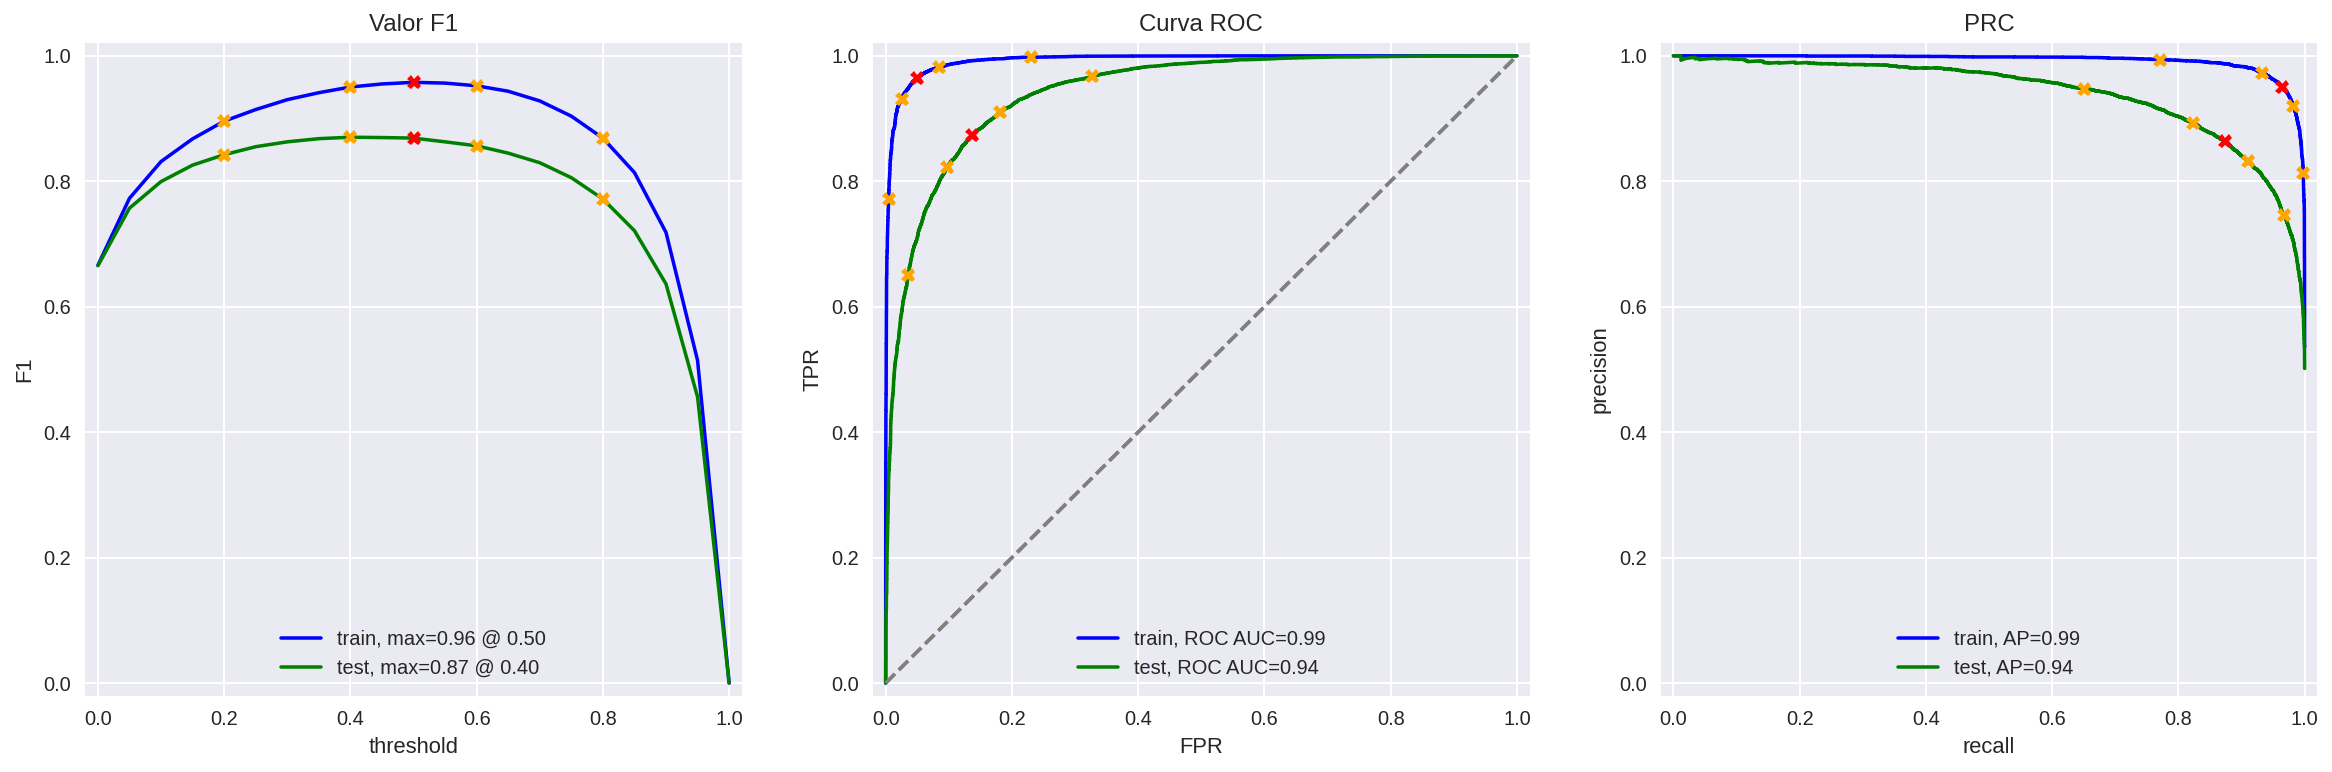

In [31]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

**Conclusiones:**

- Este modelo de LGBMClassifier con spacy y TF-IDFR obtuvo obtuvo una excelente calificación para el conjunto de entrenamiento, sin embargo para el conjunto de prueba la calificación obtenida es 9 puntos menor, es el modelo con mas sobreajuste.

## Mis reseñas

In [50]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])

"""
my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)

my_reviews.iloc[0]

review         I did not simply like it, not my kind of movie.
review_norm      i did not simply like it not my kind of movie
Name: 0, dtype: object

### Modelo 1

In [51]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(test_features_1)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.41:  i did not simply like it not my kind of movie
0.84:  well i was bored and felt asleep in the middle of the movie
0.65:  i was really fascinated with the movie
0.93:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.69:  i didn't expect the reboot to be so good writers really cared about the source material
0.06:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.19:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.29:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


**Conclusiones:**

- En este modelo le da una alta probabilidad a los dos peores comentarios, sin embargo le da una probabilidad de 0.65 al tercer comentario lo cual es acertado.

### Modelo 3

In [52]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(test_features_2)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.42:  i did not simply like it not my kind of movie
0.78:  well i was bored and felt asleep in the middle of the movie
0.65:  i was really fascinated with the movie
0.95:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.78:  i didn't expect the reboot to be so good writers really cared about the source material
0.04:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.16:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.26:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


**Conclusiones:**

- En este modelo le da una alta probabilidad a los dos peores comentarios, sin embargo le da una probabilidad de 0.65 al tercer comentario lo cual es acertado.

### Modelo 4

In [47]:
texts = my_reviews['review_norm']


my_reviews_pred_prob = model_3.predict_proba(test_features_3)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.80:  well i was bored and felt asleep in the middle of the movie
0.33:  i was really fascinated with the movie
0.97:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.74:  i didn't expect the reboot to be so good writers really cared about the source material
0.11:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.29:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.14:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


**Conclusiones:**

- En este modelo también encontramos la misma ocurrencia a los dos peores comentarios los otorga una alta probabilidad de ser un  comentario positivo.

## Conclusiones

**Conclusiones:**

- Luego de obtrner resultados de todos los modelos de procesamiento de lenguaje natural se puede llegar a la conclusión de que son bastante precisos, lo suficiente como para predecir de manera acertada si un comentario es positivo o no, 